In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
import spacy
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_csv(r"\covid19_Processed.csv")
# selected relevant features
df = pd.DataFrame(df, columns=['abstract','body_text','title'])

In [4]:
# defineing the knoledge base with the covid-19 terms and their associated synonyms
covid_dict = {
    "COVID-19": ["Coronavirus disease 2019", "SARS-CoV-2", "Novel coronavirus"],
    "Vaccine": ["COVID vaccine", "Coronavirus vaccine", "SARS-CoV-2 vaccine"],
    "Face mask": ["Mask", "Surgical mask", "N95 respirator"],
    "Social distancing": ["Physical distancing", "Social isolation", "Quarantine"],
    "Hand hygiene": ["Hand washing", "Hand sanitizing", "Hand disinfection"],
    "Pandemic": ["Global health crisis", "Outbreak", "Epidemic"],
    "PCR test": ["Polymerase chain reaction test", "COVID-19 test", "Nasal swab test"],
    "Antibody": ["Immunoglobulin", "Serology test", "Immunity"],
    "Contact tracing": ["Contact investigation", "Contact monitoring", "Exposure notification"],
    "Ventilator": ["Mechanical ventilator", "Breathing machine", "Respirator"],
    "PPE": ["Personal protective equipment", "Protective gear", "Hazmat suit"],
    "Herd immunity": ["Community immunity", "Population immunity", "Herd protection"],
    "Lockdown": ["Stay-at-home order", "Quarantine", "Shelter-in-place"],
    "Asymptomatic": ["Silent carrier", "Without symptoms", "Asymptomatic carrier"],
    "Isolation": ["Self-quarantine", "Self-isolation", "Medical isolation"],
    "Mortality rate": ["Death rate", "Fatality rate", "Case fatality rate"],
    "Incubation period": ["Latency period", "Asymptomatic period", "Symptom-free period"],
    "Close contact": ["Proximate contact", "Direct contact", "Physical contact"],
    "Immune response": ["Immunological response", "Antibody response", "Immune system response"],
    "Essential worker": ["Frontline worker", "Critical worker", "Key worker"],
    "Superspreader": ["Super-spreading event", "Outbreak amplifier", "Infectious agent"],
    "Variant": ["COVID variant", "Coronavirus variant", "SARS-CoV-2 variant"],
    "Booster": ["COVID booster", "Vaccine booster", "Additional dose"],
    "Long COVID": ["Long-haul COVID", "Post-acute COVID", "Chronic COVID"],
    "Hybrid work": ["Flexible work", "Remote work", "Virtual work"],
    "Hazard pay": ["Hero pay", "Essential pay", "Pandemic pay"],
    "Cytokine storm": ["Cytokine release syndrome", "Systemic inflammatory response", "Hyperinflammation"],
    "Breakthrough infection": ["Vaccine breakthrough", "Post-vaccination infection", "Vaccine failure"],
    "Airborne transmission": ["Aerosol transmission", "Droplet transmission", "Respiratory transmission"],
    "Mental health": ["Psychological well-being", "Emotional health", "Mental wellness"],
    "Third wave": ["COVID surge", "Outbreak resurgence", "Pandemic rebound"],
    "Antiviral drug": ["COVID treatment", "Coronavirus medication", "SARS-CoV-2 therapy"],
    "Digital health pass": ["COVID passport", "Vaccine passport", "Health certificate"]
}

In [5]:
# imported libraries for indexing and text matching
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# import nltk
from collections import defaultdict
from math import log10

# preprocessing
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords

In [6]:
# defining a function to preprocess the text 
def processed_df(text):
    text = re.sub(r'[^a-zA-Z0-9]+', ' ', text)
    text = text.lower()
    tokens=[]
    doc = nlp(text)
    for token in doc:
        if token.is_stop or token.is_punct or token.is_space or token.like_num or token.like_url or token.like_email:
            continue
        tokens.append(token.lemma_)
    return ' '.join(tokens)

In [7]:
# defined a function to preprocess both documents and query
def preprocess(text):
    text = re.sub(r'[^a-zA-Z0-9]+', ' ', text)
    doc = nlp(text)
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.like_num and not token.like_url:
            tokens.append(token.lemma_.lower())
    return tokens

In [8]:
# defining a function that returns dictionary word and relevant postings list.
def inverted_index(docs):
    inverted_index = defaultdict(list)
    for doc_id, doc in enumerate(docs):
        for token in preprocess(doc):
            inverted_index[token].append(doc_id)
    return inverted_index

In [9]:
tqdm.pandas()
df['processed_title'] = df['title'].progress_apply(lambda x: processed_df(x))

100%|██████████| 54152/54152 [02:36<00:00, 346.31it/s]


In [10]:
# converted a dataframe into a list
docs = df['processed_title'].to_list()
inverted_index = inverted_index(docs)

In [11]:
# defined a function for document scoring using TF-IDF
def rank_docs(query, inverted_index, docs):
    scores = defaultdict(float)
    query_terms = set(query)
    N = len(docs)
    max_score = 0

    for term in query_terms:
        df = len(inverted_index.get(term, []))  # Handle terms not in the index
        idf = log10((N / (df + 1)))  # Calculate IDF once per term
        for doc_id in inverted_index.get(term, []):
            tf = docs[doc_id].count(term)
            scores[doc_id] += tf * idf
            if scores[doc_id] > max_score:
                max_score = scores[doc_id]

    # Normalize scores
    if max_score > 0:
        for doc_id in scores:
            scores[doc_id] /= max_score

    # Rank documents by score
    ranked_docs = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return ranked_docs

In [12]:
# defined a function that displays all paper IDs alongside their respective similarity scores
def show_article(ranked_docs, df):
    if len(ranked_docs) == 0:
        print("There are no similar documents found.")
    else:
        for doc_id, score in ranked_docs:
            print(f'Similarity: {score:.4f}  Document: {df.paper_id[doc_id]}')

In [13]:
# defined a function to store the top 7 documents (from most similar to least similar) to calculate MRR
def store_articles(ranked_docs, df):
    if len(ranked_docs) == 0:
        return []
    else:
        return [df.title[doc_id].lower() for doc_id, _ in ranked_docs[:7]]

In [14]:
# defined a function that returns an array containing either 1 or 0, where 0 indicates that the document is not relevant and 1 indicates that the document is relevant. 
def MRR_query(question,ranked_articles_list):
    query_words = preprocess(question)
    # dictionary for entities in the KB with relative key-words
    KB_words = {}
    # list to contain all associated names
    lst = []

    for i in covid_dict.items():
        KB_words[i[0]] = preprocess(i[0])
    # list for KB words
    KB_words_list = []
    for i in KB_words.items():
        KB_words_list += i[1]
    # list to identify the common words between KB and query
    common_words = []
    for word in query_words:
        if word in KB_words_list:
            common_words.append(word)
    for key, value in KB_words.items():
        for i in common_words:
            for word in value:
                if i == word:
                    lst.append([key])
    lst.append(covid_dict['COVID-19'])
    # itertools to flaten the lists
    import itertools
    lst = list(itertools.chain(*lst))
    processes_KB = [preprocess(i) for i in lst]
    processes_KB = list(itertools.chain(*processes_KB))
    # stores the positiion of relevant articles for a given query
    res = []
    
    #This chunk of code:
        # checks the relevancy of each article based on KB-derived ground truths.
        # with a total of 3 (the key word occurrence should at least be 3).
    for i in range(len(ranked_articles_list)):
        new = ranked_articles_list[i]
        new = new.split()
        preprocess_doc = []
        for i in new:
            preprocess_doc.append(preprocess(i))
        preprocess_doc = list(itertools.chain(*preprocess_doc))
        counts = []

        for i in preprocess_doc:
            if i in processes_KB:
                counts.append(i)

        if len(counts) >= 3:
            res.append(1)
        else:
            res.append(0)
    return res

In [15]:
# defined a function that returns top 3 articles with similarity score, article ID, article title, and answer (similar chunk).
def present_results(question):
    summary = []
    query = question
    processed_query = preprocess(query)
    ranked_docs = rank_docs(processed_query, inverted_index, docs)
    if len(ranked_docs) == 0:
        print("There are no similar documents found.")
    else:
        count = 0
        for i in ranked_docs:
            if count < 5:
                print('Article ',count+1)
                print('Similarity score: ',i[1])
                print('Article Title: ', df.title[i[0]])
                print('Answer: ', df.abstract[i[0]])
                if i[1] >= 0.5:
                    summary.append(df.abstract[i[0]])
                print()
                count += 1
    return summary
            
top_docs = present_results("is there panic because of COVID-19?")

Article  1
Similarity score:  1.0
Article Title:  Panic and pandemic: narrative review of the literature on the links and risks of panic disorder as a consequence of the SARS-CoV-2 pandemic 
Answer:  escitalopram, which are first-line treatments for panic disorder, but also hydroxyzine, aiming at anxiety relief. The results reviewed here highlight the importance of considering and further investigating the impact of the current pandemic on the diagnosis and treatment of panic disorder (alone or comorbid with the COVID-19).

Article  2
Similarity score:  0.5
Article Title:  A Digital Therapeutic Intervention Delivering Biofeedback for Panic Attacks (PanicMechanic): Feasibility and Usability Study 
Answer:  Background: Panic attacks (PAs) are an impairing mental health problem that affects >11% of adults every year. PAs are episodic, and it is difficult to predict when or where they may occur; thus, they are challenging to study and treat.
Objective: The aim of this study is to present P

In [16]:
top_docs

['escitalopram, which are first-line treatments for panic disorder, but also hydroxyzine, aiming at anxiety relief. The results reviewed here highlight the importance of considering and further investigating the impact of the current pandemic on the diagnosis and treatment of panic disorder (alone or comorbid with the COVID-19).',
 'Background: Panic attacks (PAs) are an impairing mental health problem that affects >11% of adults every year. PAs are episodic, and it is difficult to predict when or where they may occur; thus, they are challenging to study and treat.\nObjective: The aim of this study is to present PanicMechanic, a novel mobile health app that captures heart rate-based data and delivers biofeedback during PAs.\nIn our first analysis, we leveraged this tool to capture profiles of real-world PAs in the largest sample to date (148 attacks from 50 users). In our second analysis, we present the results from a pilot study to assess the usefulness of PanicMechanic as a PA interv

In [17]:
combined_text = " ".join(top_docs)

In [18]:
df = df.sample(n=3000, random_state=69)

In [19]:
# taking a subset of the data
df = pd.DataFrame(df, columns=['abstract','body_text'])
df = df.rename(columns={'abstract':'target_text', 'body_text':'input_text'})
df.head()

,target_text,input_text
26624, Aging is associated with increasing severity...,A new zoonotic disease due to infection by a c...
31362,A model to predict the relative levels of resp...,"In December 2019, physicians in Wuhan, China, ..."
53059,A Japanese man suffered from acute respiratory...,Genus Orthoreovirus is one of 15 current gener...
52267,The current diagnosis of severe acute respirat...,Severe acute respiratory syndrome (SARS) cause...
28131,In the age of rapid technological advancement ...,Global supply chains are complex multi-echelon...


In [20]:
df['target_len'] = df['target_text'].apply(lambda x : len(x))
df['input_len'] = df['input_text'].apply(lambda x : len(x))
df['diff_len'] = df['input_len'] - df['target_len']
df_temp = df[df['diff_len'] < 0]
df_temp2 = df[df['diff_len'] > 0]
df_temp = df_temp[df_temp['input_len'] > 200]
df_temp.columns = ['input_text','target_text','input_len','target_len','diff_len']
df = pd.concat([df_temp2,df_temp], ignore_index=True)
df = df.drop('diff_len', axis=1)
df = df.drop('target_len', axis=1)
df = df.drop('input_len', axis=1)
df

,target_text,input_text
0, Aging is associated with increasing severity...,A new zoonotic disease due to infection by a c...
1,A model to predict the relative levels of resp...,"In December 2019, physicians in Wuhan, China, ..."
2,A Japanese man suffered from acute respiratory...,Genus Orthoreovirus is one of 15 current gener...
3,The current diagnosis of severe acute respirat...,Severe acute respiratory syndrome (SARS) cause...
4,In the age of rapid technological advancement ...,Global supply chains are complex multi-echelon...
...,...,...
2994,pre-existing health condition of overweight/ob...,23 24 25 26 J o u r n a l P r e -p r o o f dur...
2995,"In COVID-19, the mechanism of PRES is most lik...",A 66-year-old woman presented to the Emergency...
2996,"To the Editor-In 2020, the coronavirus disease...",epidemic raged around the world. As of Februar...
2997,Pembrolizumab (9) Nivolumab/Ipilimumab (6) Ipi...,https://orcid.org/0000-0002-0502-7742 Thierry ...


In [21]:
# capping the word count for input and target text
# df['target_text'] = df['target_text'].apply(lambda x: x[:600])
# df['input_text'] = df['input_text'].apply(lambda x: x[:2500])

In [22]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df,test_size=0.3)
train_df.shape , test_df.shape


((2099, 2), (900, 2))

In [27]:
# import torch
from simpletransformers.seq2seq import Seq2SeqModel,Seq2SeqArgs

model_args = Seq2SeqArgs()
# best so far epoch =14, train_loss = 2.0117043143226985, test = 2.7396971384684243}
model_args.num_train_epochs = 8
model_args.no_save = False
model_args.evaluate_during_training = True
model_args.evaluate_during_training_verbose = True
model_args.overwrite_output_dir = True
model_args.max_length = 600

# Additions
model_args.early_stopping = True
model_args.early_stopping_metric = "eval_loss"
model_args.early_stopping_patience = 3
model_args.learning_rate = 2e-5
model_args.gradient_accumulation_steps = 4
model_args.weight_decay = 0.01
model_args.save_steps = 500
model_args.save_total_limit = 2
model_args.evaluation_strategy = "steps"
model_args.eval_steps = 500
model_args.fp16 = True
model_args.warmup_ratio = 0.1
model_args.seed = 42

# Initialize model
model = Seq2SeqModel(
    encoder_decoder_type="bart",
    encoder_decoder_name="facebook/bart-large",
    args=model_args,
    use_cuda=True,
)

# model_args = Seq2SeqArgs()
# model_args.num_train_epochs = 10
# model_args.no_save = False
# model_args.evaluate_generated_text = True
# model_args.evaluate_during_training = True
# model_args.evaluate_during_training_verbose = True
# model_args.per_device_train_batch_size = 8
# model_args.overwrite_output_dir = True
# model_args.max_length = 600

# # Additions
# model_args.early_stopping = True
# model_args.early_stopping_metric = "eval_loss"
# model_args.early_stopping_patience = 3
# model_args.learning_rate = 2e-5
# model_args.gradient_accumulation_steps = 4
# model_args.weight_decay = 0.01
# model_args.save_steps = 500
# model_args.save_total_limit = 2
# model_args.evaluation_strategy = "steps"
# model_args.eval_steps = 500
# model_args.fp16 = True
# model_args.warmup_ratio = 0.1
# model_args.seed = 42

# # Initialize model
# model = Seq2SeqModel(
#     encoder_decoder_type="bart",
#     encoder_decoder_name="facebook/bart-large",
#     args=model_args,
#     use_cuda=True,
# )

In [28]:
model.train_model(train_df, eval_data=test_df)

  0%|          | 0/2099 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

Running Epoch 8 of 8:   0%|          | 0/263 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

(520,
 {'global_step': [65, 130, 195, 260, 325, 390, 455, 520],
  'eval_loss': [3.497585799958971,
   3.101017713546753,
   2.9745607641008167,
   2.8663009802500405,
   2.8092182212405734,
   2.7979040675693088,
   2.7773081991407604,
   2.774947510825263],
  'train_loss': [5.522524356842041,
   3.731376886367798,
   3.378046989440918,
   2.7547214031219482,
   2.445103645324707,
   3.1114654541015625,
   2.6790664196014404,
   3.1184778213500977]})

In [30]:
import torch
torch.save(model, 'model.pkl')

In [29]:
print(model.eval_model(train_df))
print(model.eval_model(test_df))

  0%|          | 0/2099 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 2.774947510825263}

In [ ]:
# print(model.predict([combined_text]))

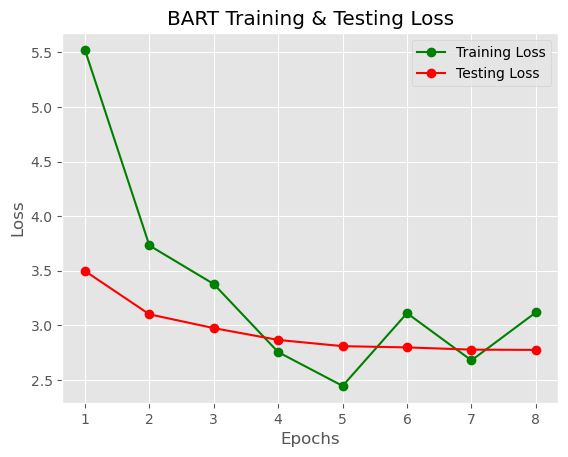

In [31]:
import matplotlib.pyplot as plt


dict1 = {'eval_loss': [3.497585799958971,
   3.101017713546753,
   2.9745607641008167,
   2.8663009802500405,
   2.8092182212405734,
   2.7979040675693088,
   2.7773081991407604,
   2.774947510825263],
  'train_loss': [5.522524356842041,
   3.731376886367798,
   3.378046989440918,
   2.7547214031219482,
   2.445103645324707,
   3.1114654541015625,
   2.6790664196014404,
   3.1184778213500977]}

epochs = [1, 2, 3, 4, 5, 6, 7, 8]
eval_loss = dict1['eval_loss']
train_loss = dict1['train_loss']

plt.plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
plt.plot(epochs , eval_loss , 'r-o' , label = 'Testing Loss')
plt.title('BART Training & Testing Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()